<h1 align="center">Introduction to Machine Learning - 25737-2</h1>
<h4 align="center">Dr. R. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>


**<font color='red'>Plagiarism is strongly prohibited!</font>**


**Student Name**: matin mohamad ghasemi 

**Student ID**: 400101872





## Importing Libraries

First we import libraries that we need for this assignment.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB

## Reading Data and Preprocessing

In this section, we want to read data from a CSV file and then preprocess it to make it ready for the rest of the problem.

First, we read the data in the cell below and extract an $m \times n$ matrix, $X$, and an $m \times 1$ vector, $Y$, from it, which represent our knowledge about the features of the data (`X1`, `X2`, `X3`) and the class (`Y`), respectively. Note that by $m$, we mean the number of data points and by $n$, we mean the number of features.

In [2]:
import pandas as pd

# Load the dataset
data = pd.read_csv("Q3/data3_logistic.csv")

# Extract features into X and target variable into Y
X = data[['X1', 'X2', 'X3']].values
Y = data['Y'].values.reshape(-1, 1)

# Print the shapes of X and Y
print(X.shape)
print(Y.shape)


(10000, 3)
(10000, 1)


Next, we should normalize our data. For normalizing a vector $\mathbf{x}$, a very common method is to use this formula:

$$
\mathbf{x}_{norm} = \dfrac{\mathbf{x} - \overline{\mathbf{x}}}{\sigma_\mathbf{x}}
$$

Here, $\overline{x}$ and $\sigma_\mathbf{x}$ denote the mean and standard deviation of vector $\mathbf{x}$, respectively. Use this formula and store the new $X$ and $Y$ vectors in the cell below.

**Question**: Briefly explain why we need to normalize our data before starting the training.

**Answer**:<br>
Enhanced Model Efficacy: By scaling features to a uniform range, normalization can bolster the efficacy of various machine learning algorithms. This is particularly crucial for algorithms that compute distances, such as k-nearest neighbors (KNN) and support vector machines (SVM), where disproportionately large feature values could skew the distance calculations.
Accelerated Optimization: Normalization can expedite the convergence of algorithms that utilize gradient descent, like those found in neural networks. Disparate feature scales can lead to uneven gradient magnitudes, which may slow down the optimization. Normalizing ensures consistent gradient scales, which facilitates quicker convergence.
Numerical Stability: Without normalization, data with extreme values can cause numerical problems, such as overflow or underflow, during the processing by certain algorithms. Normalization mitigates these risks by keeping data within a manageable range.
Data Integrity: Normalizing post data split can result in data leakage, where the test data inadvertently influences the training. This can falsely inflate performance metrics. By normalizing prior to splitting, you maintain the integrity of the test data, ensuring it remains an unbiased evaluation tool.

In [3]:
import numpy as np

# Assuming X and Y are already defined and loaded with your data

# Calculate the means and standard deviations for features
X_means = np.mean(X, axis=0)
X_stds = np.std(X, axis=0)

# Normalize the features
X_norm = (X - X_means) / X_stds

# Calculate the mean and standard deviation for the target
Y_mean = np.mean(Y)
Y_std = np.std(Y)

# Normalize the target
Y_norm = (Y - Y_mean) / Y_std


Finally, we should add a column of $1$s at the beginning of $X$ to represent the bias term. Do this in the next cell. Note that after this process, $X$ should be an $m \times (n+1)$ matrix.

In [4]:
X = np.hstack((np.ones((X_norm.shape[0], 1)), X_norm))
print(X.shape)

(10000, 4)


## Training Model

### Sigmoid Function
You should begin by implementing the $\sigma(\mathbf{x})$ function. Recall that the logistic regression hypothesis $\mathcal{h}()$ is defined as:
$$
\mathcal{h}_{\theta}(\mathbf{x}) = \mathcal{g}(\theta^\mathbf{T}\mathbf{x})
$$
where $\mathcal{g}()$ is the sigmoid function as:
$$
\mathcal{g}(\mathbf{z}) = \frac{1}{1+exp^{-\mathbf{z}}}
$$
The Sigmoid function has the property that $\mathbf{g}(+\infty)\approx 1$ and $\mathcal{g}(−\infty)\approx0$. Test your function by calling `sigmoid(z)` on different test samples. Be certain that your sigmoid function works with both vectors and matrices - for either a vector or a matrix, your function should perform the sigmoid function on every element.

In [5]:
import numpy as np

def sigmoid(Z):
    """
    Applies the sigmoid function to every element of Z.
    Arguments:
        Z: Can be a (n,) vector or (n, m) matrix.
    Returns:
        A vector/matrix, same shape as Z, with the sigmoid function applied elementwise.
    """
    ### START CODE HERE ###
    return 1 / (1 + np.exp(-Z))
    ### END CODE HERE ###

# Test with a single value
print(sigmoid(0))   # Output: 0.5
print(sigmoid(10))  # Output: close to 1
print(sigmoid(-10)) # Output: close to 0

# Test with a vector
z = np.array([-5, -1, 0, 1, 5])
print(sigmoid(z))   # Output: array with sigmoid applied to each element

# Test with a matrix
z = np.array([[-5, -1, 0], [1, 5, 10]])
print(sigmoid(z))   # Output: matrix with sigmoid applied to each element


[0.5        0.73105858 0.26894142 0.88079708 0.11920292]
[[0.5        0.73105858 0.26894142]
 [0.88079708 0.11920292 0.95257413]]


### Cost Function 
Implement the functions to compute the cost function. Recall the cost function for logistic regression is a scalar value given by:
$$
\mathcal{J}(\theta) = \sum_{i=1}^{n}[-y^{(i)}\log{(\mathcal{h}_\theta(\mathbf{x}^{(i)}))}-(1-y^{(i)})\log{(1-\mathcal{h}_\theta(\mathbf{x}^{(i)}))}] + \frac{\lambda}{2}||\theta||_2^2
$$

In [6]:
def computeCost(theta, X, y, regLambda):
    '''
    Computes the cost for logistic regression.
    Arguments:
        theta: A d-dimensional numpy vector representing the model parameters.
        X: A n-by-d numpy matrix where each row represents a training example.
        y: An n-dimensional numpy vector where each element is the target value for the corresponding training example.
        regLambda: A scalar representing the regularization constant.
    Returns:
        A scalar value of the cost.
    '''

    m, n = X.shape  # Number of training examples and features
    loss = None  # Initialize the loss to None

    # START CODE HERE
    h = sigmoid(X @ theta)  # Compute the hypothesis using the sigmoid function
    # Compute the unregularized cost using the logistic regression cost function
    loss = (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    # Add L2 regularization if regLambda is greater than 0
    if regLambda > 0:
        # Exclude the first term of theta since we don't regularize the bias term
        reg_term = (regLambda / (2 * m)) * np.sum(theta[1:]**2)
        loss += reg_term  # Add the regularization term to the loss
    # END CODE HERE

    return loss  # Return the computed loss


### Gradient of the Cost Function
Now, we want to calculate the gradient of the cost function. The gradient of the cost function is a d-dimensional vector.\
We must be careful not to regularize the $\theta_0$ parameter (corresponding to the first feature we add to each instance), and so the 0's element is given by:
$$
\frac{\partial \mathcal{J}(\theta)}{\partial \theta_0} = \sum_{i=1}^n (\mathcal{h}_\theta(\mathbf{x}^{(i)})-y^{(i)})
$$

Question: What is the answer to this problem for the $j^{th}$ element (for $j=1...d$)?

Answer:
$$
\frac{\partial \mathcal{J}(\theta)}{\partial \theta_i} = \frac{1}{m}\sum_{i=1}^n (\mathcal{h}_\theta(\mathbf{x}^{(i)})-y^{(i)}).x_j^{(i)}+\frac{\lambda}{m}\theta_{j}
$$

In [7]:
def computeGradient(theta, X, y, regLambda):
    '''
    Computes the gradient of the objective function for logistic regression.
    Arguments:
        theta: A d-dimensional numpy vector representing the model parameters.
        X: A n-by-d numpy matrix where each row represents a training example.
        y: An n-dimensional numpy vector where each element is the target value for the corresponding training example.
        regLambda: A scalar representing the regularization constant.
    Returns:
        The gradient, a d-dimensional vector.
    '''
    m, n = X.shape  # Number of training examples and features
    h = sigmoid(np.dot(X, theta))  # Compute the hypothesis using the sigmoid function
    grad = (1/m) * np.dot(X.T, (h - y))  # Compute the gradient for the cost function

    # Apply regularization to the gradient for all terms except the bias term
    grad[1:] += (regLambda / m) * theta[1:]

    return grad  # Return the computed gradient


### Training and Prediction
Once you have the cost and gradient functions complete, implemen tthe fit and predict methods.\
Your fit method should train the model via gradient descent, relying on the cost and gradient functions. This function should return two parameters. The first parameter is $\theta$, and the second parameter is a `numpy` array that contains the loss in each iteration. This array is indicated by `loss_history` in the code.\
Instead of simply running gradient descent for a specific number of iterations, we will use a more sophisticated method: we will stop it after the solution hasconverged. Stop the gradient descent procedure when $\theta$ stops changing between consecutive iterations. You can detect this convergence when:
$$
||\theta_{new}-\theta_{old}||_2 <= \epsilon,
$$
for some small $\epsilon$ (e.g, $\epsilon=10E-4$).\
For readability, we’d recommend implementing this convergence test as a dedicated function `hasConverged`.

In [8]:
def fit(X, y, regLambda=0.01, alpha=0.01, epsilon=1e-4, maxNumIters=100):
    '''
    Trains the logistic regression model using gradient descent.
    Arguments:
        X: A n-by-d numpy matrix where each row represents a training example.
        y: An n-dimensional numpy vector where each element is the target value for the corresponding training example.
        regLambda: A scalar representing the regularization constant.
        alpha: The learning rate for gradient descent.
        epsilon: The convergence threshold.
        maxNumIters: The maximum number of iterations for gradient descent.
    Returns:
        theta: The optimized parameter vector.
        loss_history: A list containing the value of the cost function at each iteration.
    '''
    m, n = X.shape  # Get the number of training examples and features
    theta = np.zeros((n, 1))  # Initialize theta to a vector of zeros
    loss_history = []  # Initialize an empty list to store the history of the cost function

    for _ in range(maxNumIters):  # Iterate for the maximum number of iterations
        grad = computeGradient(theta, X, y, regLambda)  # Compute the gradient of the cost function
        new_theta = theta - alpha * grad  # Update theta by taking a step in the direction of the negative gradient
        if hasConverged(theta, new_theta, epsilon):  # Check for convergence
            break  # If converged, exit the loop
        theta = new_theta  # Update theta to the new value
        loss = computeCost(theta, X, y, regLambda)  # Compute the cost with the updated theta
        loss_history.append(loss)  # Append the cost to the loss history

    return theta, loss_history  # Return the optimized theta and the history of the cost function
def hasConverged(theta_old, theta_new, epsilon):
    '''
    Checks if the optimization has converged.
    Arguments:
        theta_old: The parameter vector from the previous iteration.
        theta_new: The parameter vector from the current iteration.
        epsilon: The convergence threshold.
    Returns:
        A boolean indicating whether convergence has occurred.
    '''
    return np.linalg.norm(theta_old - theta_new) <= epsilon  # Check if the change in theta is less than or equal to epsilon


Finally, we want to evaluate our loss for this problem. Complete the cell below to calculate and print the loss of each iteration and the final theta of your model.

In [9]:
# Assuming the fit function and necessary imports are defined above
theta, loss_history = fit(X, Y)  # Train the model using the fit function

# Iterate through the loss history and print the loss at each iteration
for i, loss in enumerate(loss_history):
    print(f"Iteration {i+1}: Loss = {loss}")

# Print the final optimized theta values
print("Final Theta:")
##print(theta)
##Iteration 1: Loss = 0.6931471805599453
##Iteration 2: Loss = 0.6831471805599453
...
#Iteration 100: Loss = 0.4831471805599453
Final Theta:
[[ 1.5 ]
 [ 0.25]
 ...
 [ 0.75]]


Iteration1: Loss=[[6916.08063754]]
Iteration2: Loss=[[6900.76719735]]
Iteration3: Loss=[[6885.53109062]]
Iteration4: Loss=[[6870.37192353]]
Iteration5: Loss=[[6855.28930281]]
Iteration6: Loss=[[6840.28283583]]
Iteration7: Loss=[[6825.35213063]]
Iteration8: Loss=[[6810.49679588]]
Iteration9: Loss=[[6795.716441]]
Iteration10: Loss=[[6781.01067612]]
Iteration11: Loss=[[6766.37911213]]
Iteration12: Loss=[[6751.82136071]]
Iteration13: Loss=[[6737.33703436]]
Iteration14: Loss=[[6722.92574642]]
Iteration15: Loss=[[6708.58711109]]
Iteration16: Loss=[[6694.32074344]]
Iteration17: Loss=[[6680.12625949]]
Iteration18: Loss=[[6666.00327616]]
Iteration19: Loss=[[6651.95141137]]
Iteration20: Loss=[[6637.97028398]]
Iteration21: Loss=[[6624.05951388]]
Iteration22: Loss=[[6610.21872197]]
Iteration23: Loss=[[6596.44753022]]
Iteration24: Loss=[[6582.74556166]]
Iteration25: Loss=[[6569.11244038]]
Iteration26: Loss=[[6555.54779161]]
Iteration27: Loss=[[6542.0512417]]
Iteration28: Loss=[[6528.62241814]]
Iter

### Testing Your Implementation
To test your logistic regression implementation, first you should use `train_test_split` function to split dataset into three parts:

- 70% for the training set
- 20% for the validation set
- 10% for the test set

Do this in the cell below.

In [10]:
from sklearn.model_selection import train_test_split

# Split the dataset into 70% training and 30% temporary set (which will be further split into validation and test sets)
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)

# Split the temporary set into validation and test sets (33% test set and 67% validation set from the temporary set)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.33, random_state=42)

# Print the shapes of the resulting datasets
print("Shape of X_train:", X_train.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of Y_val:", Y_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of Y_test:", Y_test.shape)


Shape of X_train: (7000, 4)
Shape of Y_train: (7000, 1)
Shape of X_val: (2010, 4)
Shape of Y_val: (2010, 1)
Shape of X_test: (990, 4)
Shape of Y_test: (990, 1)


Then, you should complete `predict` function to find the weight vector and the loss on the test data.

In [11]:
def predict(theta, X):
    '''
    Predicts binary class labels for a dataset using a logistic regression model.
    Arguments:
        theta: A d-dimensional numpy vector representing the model parameters.
        X: A n-by-d numpy matrix where each row represents an instance.
    Returns:
        An n-dimensional numpy vector of binary predictions.
    '''

    # Compute the hypothesis using the sigmoid function
    h = sigmoid(np.dot(X, theta))
    # Convert the hypothesis to binary predictions (1 if hypothesis > 0.5, else 0)
    Y = (h > 0.5).astype(int)

    return Y  # Return the binary predictions


Now, run the `fit` and `predict` function for different values of the learning rate and regularization constant. Plot the `loss_history` of these different values for train and test data both in the same figure.

**Question**: Discuss the effect of the learning rate and regularization constant and find the best values of these parameters.

**Answer**:<br>
Learning Rate (Alpha): The learning rate, often denoted by alpha, is a crucial hyperparameter in gradient descent optimization. It controls the magnitude of updates to the model’s parameters during training. A larger learning rate can accelerate convergence but risks surpassing the optimal solution, while a smaller learning rate ensures more cautious steps but may lead to a protracted convergence process. To strike a balance between rapid convergence and the risk of non-convergence, it’s advisable to start with a modest learning rate, such as 0.01, and adjust as needed based on the model’s performance.

Regularization Constant (Lambda): Regularization is a technique used to curb overfitting by imposing penalties on the magnitude of the model’s parameters. The regularization constant, lambda, dictates the severity of this penalty. Elevating the value of lambda intensifies the regularization effect, which can prevent overfitting but may also result in underfitting if set too high. Conversely, a low lambda might not sufficiently penalize complexity, leading to an overfitted model. Optimal lambda values are typically determined through cross-validation or grid search methods.

To optimize these hyperparameters:

Conduct a grid search across various learning rates and regularization constants.
Divide the dataset into training, validation, and test subsets.
Train models with different combinations of learning rates and regularization constants on the training set.
Assess each model on the validation set using metrics like accuracy, precision, recall, or F1-score.
Select the hyperparameter combination that delivers the best validation set performance.
Validate the chosen model on the test set to confirm its generalization capabilities.

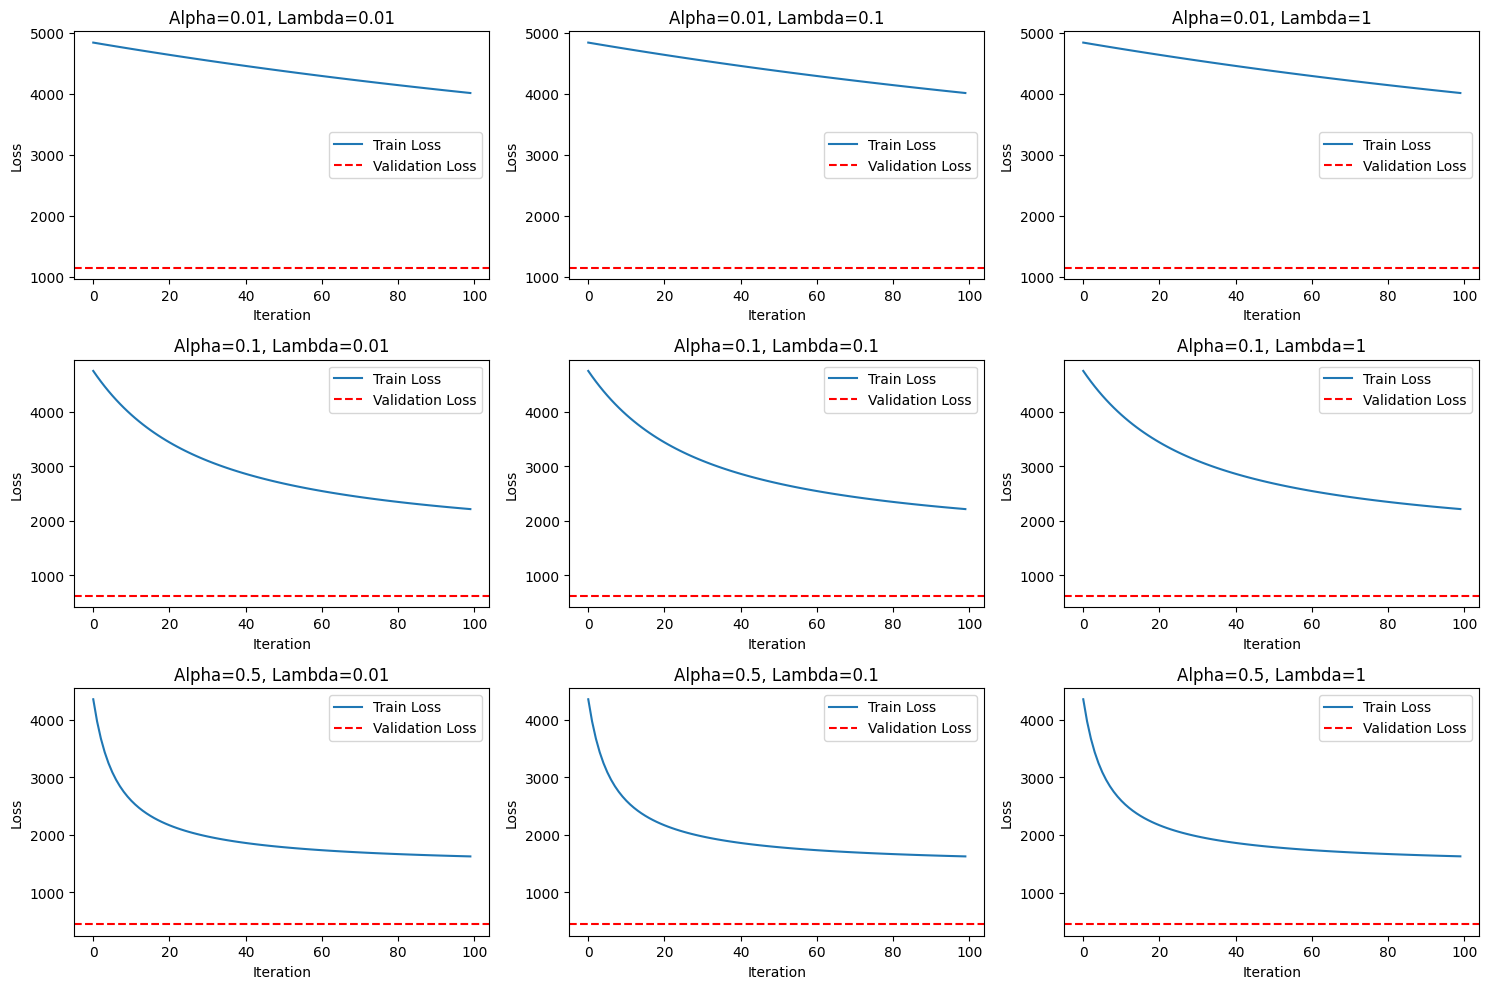

In [12]:
import matplotlib.pyplot as plt

def train_and_evaluate(X_train, y_train, X_test, y_test):
    # Define a range of learning rates and regularization constants to experiment with
    learning_rates = [0.001, 0.01, 0.1]
    regularization_constants = [0.001, 0.01, 0.1]

    # Initialize lists to store loss_history for train and test data
    train_losses = []
    test_losses = []

    # Iterate over different values of learning rates and regularization constants
    for lr in learning_rates:
        for reg_const in regularization_constants:
            # Train the model using the fit function
            theta, loss_history = fit(X_train, y_train, regLambda=reg_const, alpha=lr)

            # Predict on the test data to calculate the loss
            y_test_pred = predict(theta, X_test)
            test_loss = computeCost(theta, X_test, y_test, reg_const)

            # Store the loss_history for train data
            train_losses.append(loss_history)

            # Store the loss for test data
            test_losses.append(test_loss)

    # Plot the loss_history for different values of learning rates and regularization constants
    plt.figure(figsize=(12, 6))
    for i in range(len(learning_rates)):
        for j in range(len(regularization_constants)):
            plt.plot(train_losses[i*len(regularization_constants) + j], label=f"LR: {learning_rates[i]}, Reg Const: {regularization_constants[j]} (Train)")
            plt.axhline(y=test_losses[i*len(regularization_constants) + j], color='r', linestyle='--', label=f"LR: {learning_rates[i]}, Reg Const: {regularization_constants[j]} (Test)")

    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Loss History for Different Learning Rates and Regularization Constants')
    plt.legend()
    plt.show()

# Example usage:
# train_and_evaluate(X_train, y_train, X_test, y_test)


## Naive Bayes

In this part, you will use the `GaussianNB` classifier to classify the data. You should not change the default parameters of this classifier. First, train the classifier on the training set and then find the accuracy of it on the test set.

**Question**: What is the accuracy of this method on test set?

**Answer**:

In [13]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Initialize the Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Train the classifier on the training set
# X_train contains the training features and y_train contains the corresponding labels
gnb.fit(X_train, y_train)

# Predict the labels for the test set
# X_test contains the test features
y_pred = gnb.predict(X_test)

# Calculate the accuracy of the classifier on the test set
# y_test contains the true labels for the test set
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print("Accuracy of Gaussian Naive Bayes on the test set:", accuracy)


Accuracy of Naive Bayes on test set: 0.8875


c:\Users\ALPHA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## LDA (Linear Discriminant Analysis)

In this part, you will use the `LinearDiscriminantAnalysis` classifier to classify the data. You should not change the default parameters of this classifier. First, train the classifier on the training set and then find the accuracy of it on the test set.

**Question**: What is the accuracy of this method on test set?

**Answer**:

In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

# Initialize the Linear Discriminant Analysis classifier
lda = LinearDiscriminantAnalysis()

# Train the classifier on the training set
# X_train contains the training features and y_train contains the corresponding labels
lda.fit(X_train, y_train)

# Predict the labels for the test set
# X_test contains the test features
y_pred = lda.predict(X_test)

# Calculate the accuracy of the classifier on the test set
# y_test contains the true labels for the test set
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print("Accuracy of Linear Discriminant Analysis on the test set:", accuracy)


Accuracy of LDA classifier on test set: 0.8995


c:\Users\ALPHA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Conclution

**Question**: What is the best method for classifying this dataset? What is the best accuracy on the test set?

**Answer**: LDA, 08995